### Create the data

In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [1]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [29]:
# create spiral

X = torch.zeros(N * C, D).to(device) # features
y = torch.zeros(N * C, dtype=torch.long).to(device) # target variable

# クラスごとに作成する。
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)

    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    # 等間隔で同じ幅だけ作る。基準を作っているので、sin, cosがかぶる
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        
        # 2次元の値を入れていく。なので、Xのインデックスが1津でもうまくいく
        # indexをつかうのはあまり筋が良くない気もする
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


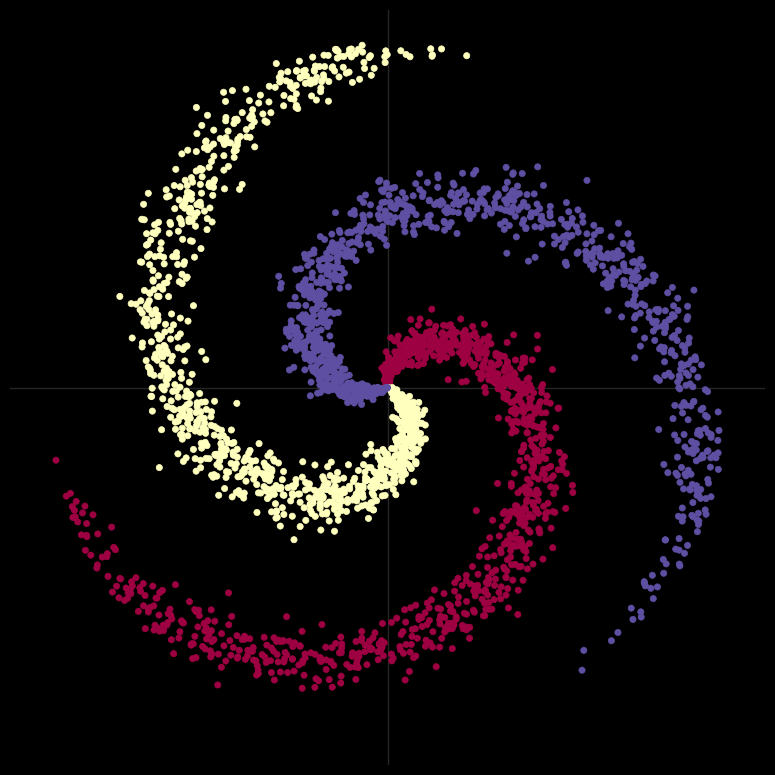

In [30]:
# visualise the data
plot_data(X, y)

### Linear model

learning_rate = 1e-3
lambda_l2 = 1e-5 # weight decay用

In [41]:
nn.Linear(D, H)

Linear(in_features=2, out_features=100, bias=True)

In [38]:
# 完全なlinearモデルを作ってみる。

model = nn.Sequential(nn.Linear(D, H), # インプットデータの特徴量次元, 中間層の次元
                      nn.Linear(H, C) # 中間層の次元, アウトプットの次元
                      )
# CPU or GPU対応
model.to(device)

# lossの作成
criterion = torch.nn.CrossEntropyLoss()

# optimizerの作成
# SGD with weight decay
# なにで微分するかを明確にしてる。 model.parameters()はgeneraterで、Wとバイアスを持っている
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [40]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[-0.1254, -0.1214],
        [ 0.6944,  0.5109],
        [ 0.2020, -0.2280],
        [-0.2715, -0.2159],
        [ 0.1746,  0.2528],
        [ 0.3096, -0.3288],
        [-0.3828,  0.0191],
        [-0.1003, -0.5044],
        [ 0.0335,  0.6016],
        [-0.6361, -0.3823],
        [ 0.1539,  0.6976],
        [-0.2182, -0.3683],
        [ 0.5511,  0.2682],
        [ 0.4048, -0.1355],
        [ 0.4767,  0.2855],
        [-0.5909, -0.4806],
        [-0.3223, -0.6598],
        [ 0.0144, -0.0990],
        [-0.1313, -0.2415],
        [-0.3458, -0.2490],
        [ 0.6458,  0.3188],
        [ 0.2803,  0.4092],
        [-0.1012,  0.5081],
        [-0.2465,  0.0406],
        [-0.6287,  0.1556],
        [ 0.5455,  0.4683],
        [ 0.0218,  0.0833],
        [ 0.0331, -0.6308],
        [ 0.0563,  0.2872],
        [ 0.0642,  0.1144],
        [ 0.6314, -0.6422],
        [ 0.5405,  0.6446],
        [ 0.6983, -0.0827],
        [ 0.3673,  0.2410],
        [-0.0081,  0.0153]

In [47]:
# Feed forward to get the logits
y_pred = model(X)
    
# Compute the loss and accuracy
loss = criterion(y_pred, y)
loss

tensor(1.0581, grad_fn=<NllLossBackward>)

In [50]:
loss.grad

<ipython-input-50-09a6243c8d35>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  loss.grad


In [ ]:
# Training１
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y) # tensor型が与えられてる
    score, predicted = torch.max(y_pred, 1) # その中でもっとも値の大きいものを予測値とする
    acc = (y == predicted).sum().float() / len(y)

    # loss.item()で単純な値のみ取れる
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    # 購買の初期化
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    # tensorクラスのgrad_fnに値が入る(gradのところにある)
    loss.backward()
    
    # Update params
    # その値を使って定義した方針でモデルのパラメタを更新する
    # 最適化問題を解くわけではないので、かんたんにかける
    optimizer.step()

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


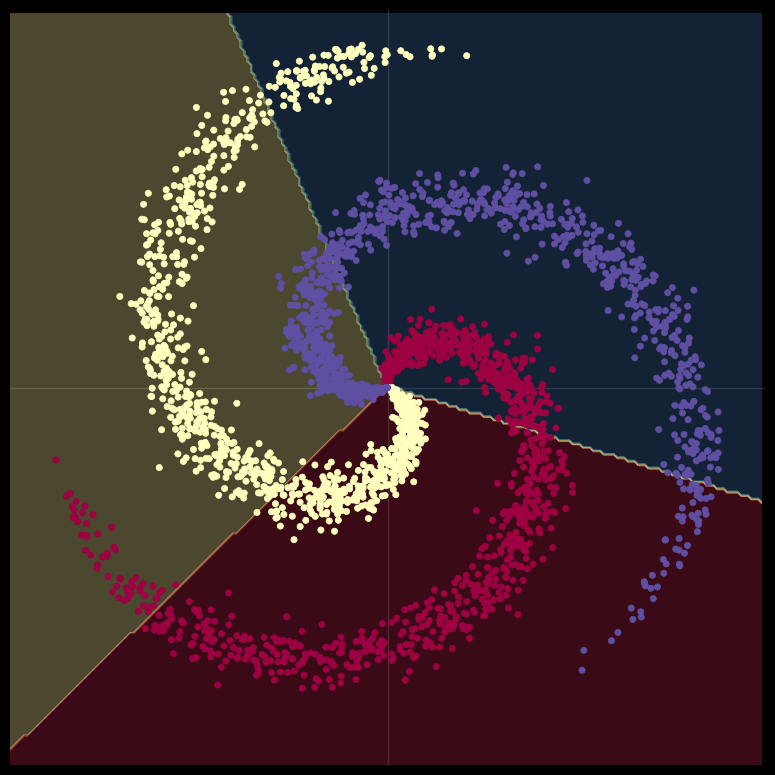

In [33]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Two-layered network

In [34]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [51]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(), # activationを追加する
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
# optimizerをadamに
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.197418, [ACCURACY]: 0.941


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


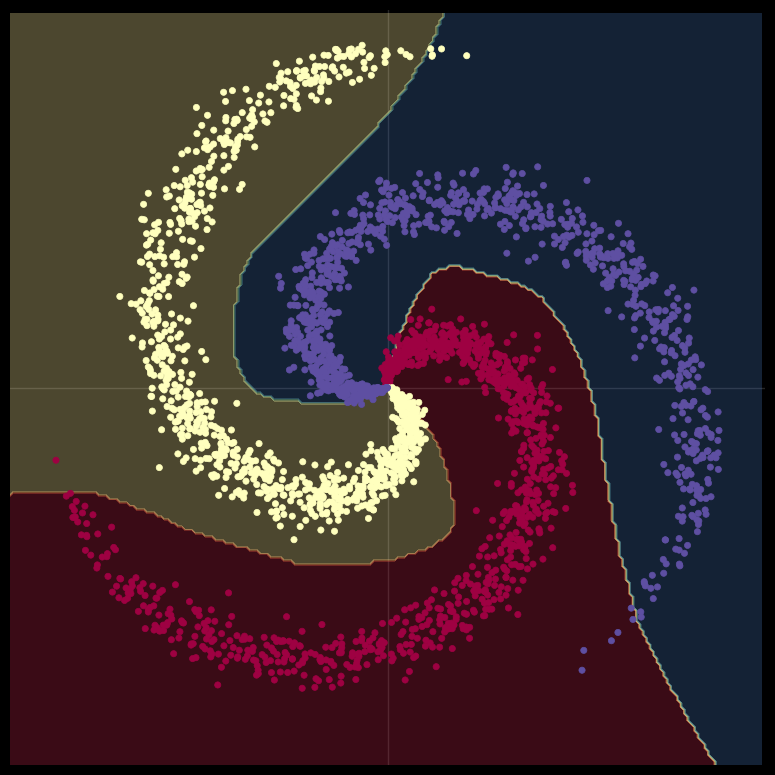

In [36]:
# Plot trained model
print(model)
plot_model(X, y, model)